### How Accurate are Polls?<br> An Analysis of Senate Election Polling Data

By William Meagher<br>
Published 5/16/22

##### Table of Contents:
1. Introduction
2. Data Collection
    1. Polling Data
    2. Restults Data
    3. Merging
3. Exploratory Data Analysis and Hypothesis Testing
    1. By Party
    2. Sponsored vs Unsponsored Polls
    3. Pollster Rating
    4. Poll Survey Method
    5. Poll Sample Size
4. Conclusion

#### 1. Introduction

Election polling is relied on by many voters and politicians when determining the state of an upcoming election. Polling data may be used by voters to decide whether or not they want to vote and by politicians to determine where to allocate their resources. But are the polls that people put their faith in to gain an understanding of the upcoming election really accurate? In this project, I will examine data from senate elections polling and comparing it to the actual election results in an attempt to gain insights. FiveThirtyEight is one of the most trusted sources of polling data. I will be examining the polls listed on fivethirtyeight and attempting to gain insight into the polls accuracy based off of available data about the pollster, their methods, and other details. I chose fivethirtyeight as my source for polls because it is the source that I typically use when I look at polling data so I was curious to examine the accuracy of the data on the site. In this analysis I will limit myself to just Senate polls. I chose to do this because senate races generally take a back seat on the national stage so people are not generally as familiar with senate races and candidates. I thought that this may result in more interesting and consistent results as I doubt there is as much swing in public opinion over the course of a senate race.

Links<br>
Fivethirtyeight polls policy and faqs https://fivethirtyeight.com/features/polls-policy-and-faqs/ <br>
Page where the results data was sourced https://dataverse.harvard.edu/file.xhtml?fileId=4300300&version=5.0

In [111]:
# import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import urllib.request
import scipy.stats as stats
from operator import itemgetter
from io import StringIO

#### 2. Data Collection


##### 2.1 Polling Data

We start by retreiving polling data for senate elections from fivethirtyeight. The data that is being pulled is from 2018-2021.

In [112]:
# retreieve polling data from fivethirtyeight
POLLS_URL = "https://projects.fivethirtyeight.com/polls/data/senate_polls_historical.csv"
polling_data = pd.read_csv(POLLS_URL)

Next we need to clean up the data a little bit so it is easier to use. Since the polling data does not include the actual result of the election it will need to be merged with a table containing the actual results of the election in order to gauge the accuracy of the polling data.

In [113]:
# get just the fields we need from the polling data
polling_data = polling_data.filter(items=['pollster', 'pollster_rating_id', 'fte_grade', 'methodology', 'state', 'stage', 'start_date', 'end_date', 'sample_size', 'partisan', 'election_date', 'party', 'candidate_name', 'pct'])

In [114]:
# convert dates to dtaetimes
polling_data['end_date'] = pd.to_datetime(polling_data['end_date'], format="%m/%d/%y")
polling_data['start_date'] = pd.to_datetime(polling_data['start_date'], format="%m/%d/%y")
polling_data['election_date'] = pd.to_datetime(polling_data['election_date'], format="%m/%d/%y")

# get year of election so data can be merged with actual election results
polling_data['year'] = pd.DatetimeIndex(polling_data['election_date']).year

# get the days until the election when the poll was completed
polling_data['until_election'] = (polling_data.election_date - polling_data.end_date).dt.days

# map our party to a full party name so it can be joined with results data
party_map = {
    'DEM': 'DEMOCRAT',
    'REP': 'REPUBLICAN',
}
polling_data['party'] = polling_data['party'].map(lambda x: party_map.get(x, 'OTHER'))

# uppercase state and stage for joining purposes
polling_data['state'] = polling_data['state'].str.upper()
polling_data['stage'] = polling_data['stage'].str.upper()

# get just last name of candiate and set it as candiate_last
polling_data['candidate_name'] = polling_data['candidate_name'].str.split().apply(itemgetter(-1)).str.upper()
polling_data = polling_data.rename(columns = {'candidate_name':'candidate_last'})

##### 2.2 Election Results

We now will retreive and clean up the data for the results of the elections for which we have polling data

In [115]:
# the website has some sort of scraping prevention so to get around that we add a broswer to the header so it thinks the request is from a browser
RESULTS_URL = 'https://dataverse.harvard.edu/api/access/datafile/4300300?format=original&gbrecs=true'
headers = {
    'user-agent': 'Mozilla/5.0',
}

# make request and read data
results_request = urllib.request.Request(RESULTS_URL, headers=headers)
results_response = urllib.request.urlopen(results_request).read()

# this data uses latin1 enoding, using utf-8 crashed
raw_results_data = results_response.decode('latin1')

# import data into a dataframe
results_data = pd.read_csv(StringIO(raw_results_data))

Cleaning up the Results Data

In [116]:
# get just results for senate races
results_data = results_data[results_data['office'] == "US SENATE"]

# convert candidatevotes and totalvotes into one column that is the percentage of received votes
results_data['acutal_pct'] = round(results_data['candidatevotes']/results_data['totalvotes'] * 100, 2)

# remove all data where the canditate failed to get 20% of the vote
results_data = results_data[results_data['acutal_pct'] >= 20]

# filter down the columns to be just the ones we need
results_data = results_data.filter(items=['year', 'state', 'stage', 'candidate', 'party_simplified', 'acutal_pct'])

# remove any data where the candidate is not listed
results_data = results_data[results_data['candidate'].notnull()]

# uppercase state and stage for joining purposes
results_data['state'] = results_data['state'].str.upper()
results_data['stage'] = results_data['stage'].str.upper()

# get just last name of candiate and set it as candiate_last, also set set party_simplified to just party
results_data['candidate'] = results_data['candidate'].str.split().apply(itemgetter(-1)).str.upper()
results_data = results_data.rename(columns = {'candidate':'candidate_last', 'party_simplified':'party'})

# map the stage of the election to be consistent with the polling table
stage_map = {
    "GEN": "GENERAL",
    "RUNOFF": "RUNOFF"
}
results_data['stage'] = results_data['stage'].map(stage_map)

# map our party to either a major party or other for joining
results_data['party'] = results_data['party'].map(lambda x: x if ((x == "REPUBLICAN") |( x == "DEMOCRAT")) else "OTHER")

I decided to remove all data where the candidate failed to get at least 20% of the vote because I feel that predictions of longshot candidates are not as valuable as predictions about candidates that are actually in the running. Because US Senate races are a winner take all race, getting 20% of the vote is insignificant and I deem the accuracy of polls predicting candidates who get very few votes of less importance. Furthermore it is useful because when looking at percentage error statistics, candidates receiving little to no votes can result in huge errors resulting in very high percentage error which can skew the data.

##### 2.3 Merging the Data

We now merge the data from the two tables together to result in one table that has all the fields needed for analysis. After merging the data we will use the actual result combined with the predicted result to get the residual and other meaningful data measurements.

In [117]:
print(polling_data['state'].count())
# join together our polling and results data so we have the guessed and actual values all in one table
data = pd.merge(polling_data, results_data,  how='inner', on=['state','stage','party','year','candidate_last'])
print(data['state'].count())

4593
3418


I chose to join the tables on these fields as a way to ensure that the polling data was being correctly matched with the corresponding actual results. I assumed that no individual senate race held in the same year would have multiple candidates that were from the same party and had the same last name. I chose to do it this way and not match the candidates full name because a lot of the names were slightly different between the two data sets. This approach allowed me to keep the maximum number of results while minimizing the risk of two different results being mapped to the same data point. An alternate approach where I matched to the full name would have resulted in less data to work with but a higher certainty that all the matched data was absolutely correct.

In [118]:
# get useful metrics by which the data can be viewed
data['residual'] = data['pct'] - data['acutal_pct']
data['abs_residual'] = abs(data['residual'])

Sometimes its important to see not just the error of the poll, but which direction off the polls tend to be. This is why I chose to keep the standard residual and percent off and not just the data with absolute units. For example, do the polls tend to over or underestimate the number of votes candidates receive.

In [119]:
# get trendline and then set normalized residual to be difference between trendline and the acutal value
slope, intercept, r_value, p_value, std_err = stats.linregress(data['until_election'], data['abs_residual'])


data['norm_residual'] = (data['until_election'] * slope + intercept) - data['abs_residual']
print('y = ' + str(slope) + '*x + ' + str(intercept))
print('r value:' + str(r_value))
print('p value:' + str(p_value))

y = 0.008451646949130833*x + 4.214975517179882
r value:0.21953157085474737
p value:1.4184839524178508e-38


This formula indicates that each day values get on average .008 percent closer to the actual percentage of votes a candidate will receive. Additionally, the intercept is 4.12 which indicates that at the day of the election there is still an absolute residual on average of 4.21. It makes sense that data becomes more accurate as it becomes closer to the election because more people have decided which candidate they are voting for and significant events during campaigning have taken place i.e speeches, scandal, ect which may have been impossible to account for in prior polling. The r value in this case is low which means that a lot of the deviation is not accounted for by the trendline but the p value is well below the .05 significance threshold which definitely means that there is a correlation between time until election and the residual.

In [120]:
# functions for easier graphing

# adds a trend line to the input plot
def trend_line(plot, df, x_col, y_col, color=None):
    trend_line = np.polyfit(df[x_col], df[y_col], 1)
    x = np.linspace(df[x_col].min(), df[x_col].max(), 10)
    y = trend_line[0] * x + trend_line[1]
    plot.plot(x, y, linewidth=3, color=color)

# scatter plots the input data with option to automatically add a trendline
def scatter(plot, df, x_col, y_col, color=None, label=None, best_fit=True):
    if best_fit:
        trend_line(plot, df, x_col, y_col, color)

    plot.scatter(df[x_col], df[y_col], 5, color=color, label=label)

#### 3. Exploratory Data Analysis and Hypothesis Testing
##### 3.1 Analysis by Party

I decided to start by looking at the data by a split by party. I've heard previously that Republicans tend to poll poorly but have a larger turnout on election day. This happened in 2016 where polls were showing Hillary Clinton with a large lead but she ended up losing the election. If this is a significant factor then we should be able to tell from the data when graphed by party.

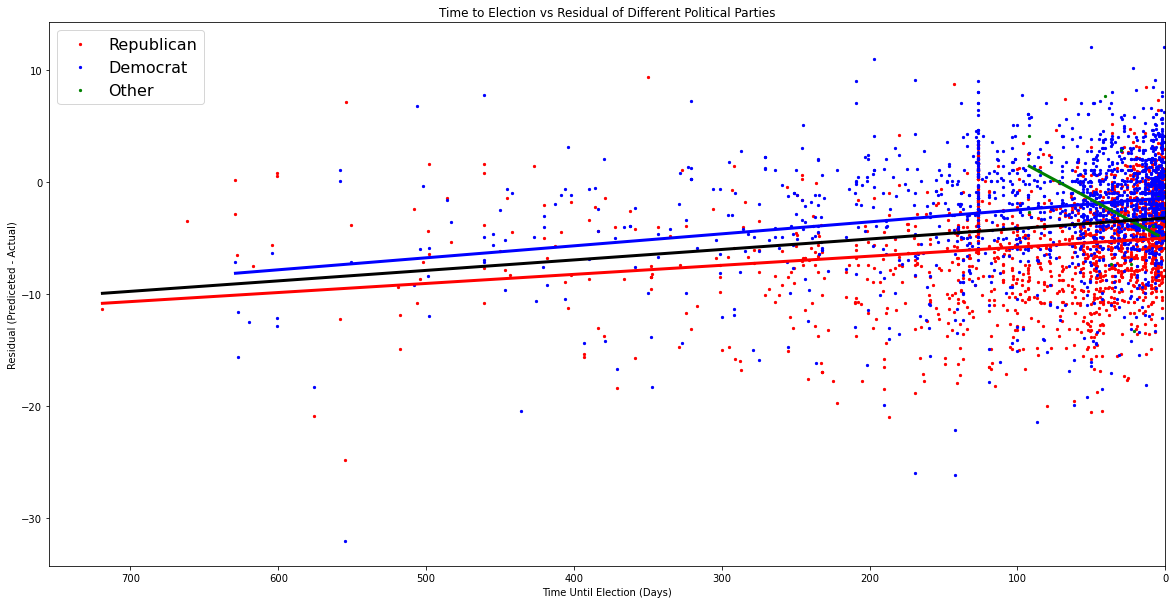

In [121]:
# split data up into 3 different tables
data_r = data[data['party'] == "REPUBLICAN"]
data_d = data[data['party'] == "DEMOCRAT"]
data_o = data[data['party'] == "OTHER"]

# set graph size
plt.figure(figsize = (20, 10))

# invert axis so start of election(0 Days until election) is at the end of the graph this way time moves from left to right
plt.gca().invert_xaxis()

# set title and labels
plt.title("Time to Election vs Residual of Different Political Parties")
plt.xlabel("Time Until Election (Days)")
plt.ylabel("Residual (Prediceted - Actual)")

# plot data
scatter(plt, data_r, 'until_election', 'residual', 'red', 'Republican')
scatter(plt, data_d, 'until_election', 'residual', 'blue', 'Democrat')
scatter(plt, data_o, 'until_election', 'residual', 'green', 'Other')

# add overall trend line
trend_line(plt, data, 'until_election', 'residual', 'black')

# add legend for context
plt.legend(loc="upper left", prop={'size': 16})

# lim x so plot ends at election day
plt.xlim(None, 0)

plt.show()

This graph shows that polling for Democrats and Republicans gets more accurate the closer we get to the day of the election. The closer to 0, the more accurate the poll. It does however show that other (third party) candidates' polls tend to get less accurate the closer to election day. We will look into this to see if this is a significant trend or just a coincidence resulting from the relatively low number of poles of other candidates.

We also see from this graph that Democrats tend to be predicted to get a higher percentage of the vote compared to their Republican counterparts. This is demonstrated by the 2-3 point gap between the trend lines for Republicans and Democrats. We will look more into this later to see if this trend is significantly significant. 

An interesting thing that is shown by this graph is that all candidates are generally predicted by polls to do worse than they actually do. A potential reason for why polls seem to under predict is probably because most polls have not sure as an option and the farther away the election is, the higher percentage of people will not be informed and more likely to answer that they are not sure. I am assuming that most of these polls have a "not sure" or "I will not be voting option" that are not present on actual ballots. This leads to a lower predicted percentage of votes compared to the actual value because those who have not made up their mind at the time of the polls will eventually contribute to one of the candidates' percentages.


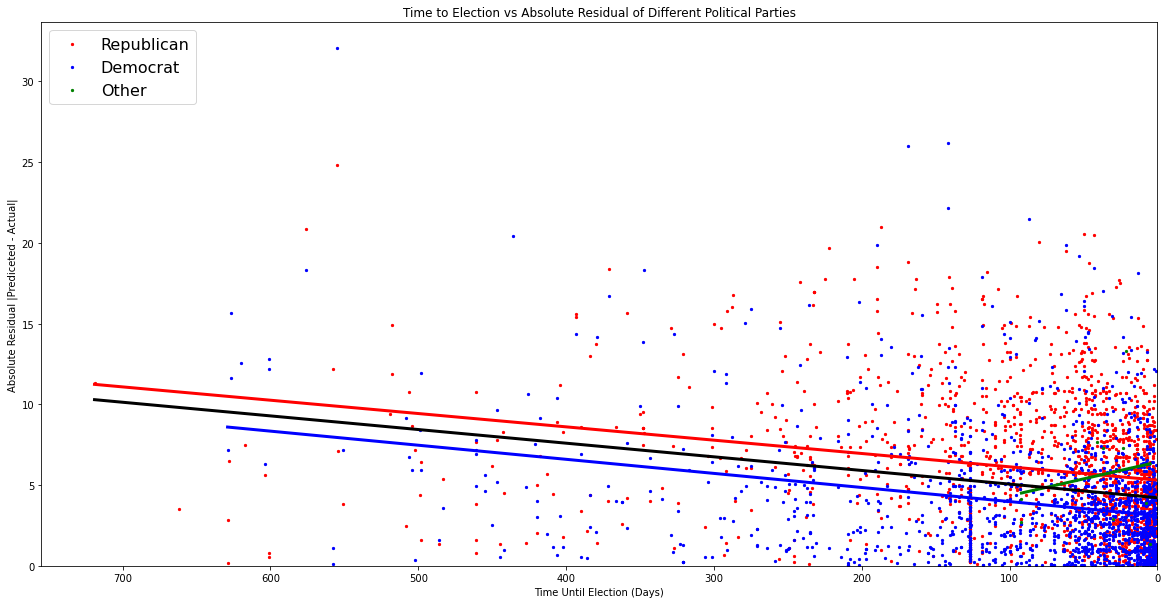

In [122]:
# set graph size
plt.figure(figsize = (20, 10))

# invert axis so start of election(0 Days until election) is at the end of the graph this way time moves from left to right
plt.gca().invert_xaxis()

# set title and labels
plt.title("Time to Election vs Absolute Residual of Different Political Parties")
plt.xlabel("Time Until Election (Days)")
plt.ylabel("Absolute Residual |Prediceted - Actual|")

# plot data
scatter(plt, data_r, 'until_election', 'abs_residual', 'red', 'Republican')
scatter(plt, data_d, 'until_election', 'abs_residual', 'blue', 'Democrat')
scatter(plt, data_o, 'until_election', 'abs_residual', 'green', 'Other')

# add overall trend line
trend_line(plt, data, 'until_election', 'abs_residual', 'black')

# add legend for context
plt.legend(loc="upper left", prop={'size': 16})

# lim x and y so plot x ends at election day y and starts at 0 which is the min possible error
plt.xlim(None, 0)
plt.ylim(0)

plt.show()

This chart demonstrates the error in absolute terms. While it does not give the full picture of how the polls are wrong it does give a better visual of how the polls become more accurate as time progresses. It also better illustrates the strange trend of other (third party) candidates' polls getting less accurate as time progresses. Let's see if this is an actual trend or just a coincidence.

In [145]:
slope, intercept, r_value, p_value, std_err = stats.linregress(data_o['until_election'], data_o['abs_residual'])
print('r value:' + str(r_value))
print('p value:' + str(p_value))

r value:-0.18344819098208864
p value:0.6366050058756489


We see from this that the trendline is not stastically significant. This makes sense because we expect that data should get better the closer we get to the election. It is very likely that with more data the trendline will become more like the overall trendline.

Since our data gets more accurate the closer we get to the election a term that reflects the actual error compared to the expected error was created. The farther below the expected error the poll is the better the score. This term is called normalized residual. The higher the normalized residual the better the poll. This is important as it provies a way to compare polls from different times. Without it it would be unfair to evaultate a poll fromm 300 days before the election to one 10 days from the election. 

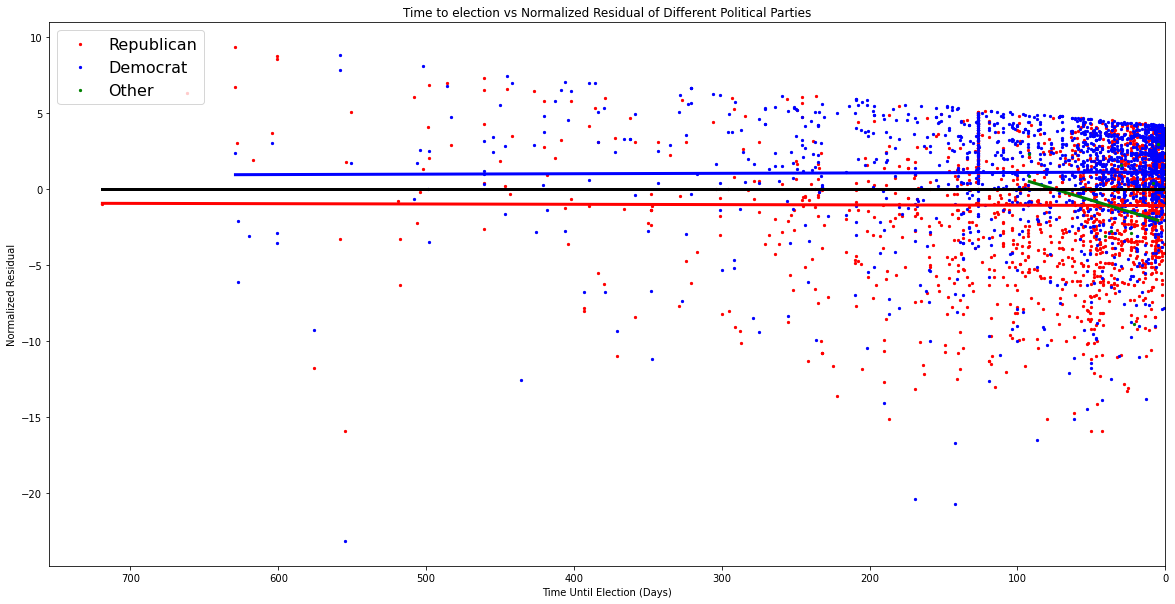

In [123]:
# set graph size
plt.figure(figsize = (20, 10))

# invert axis so start of election(0 Days until election) is at the end of the graph this way time moves from left to right
plt.gca().invert_xaxis()

# set title and labels
plt.title("Time to election vs Normalized Residual of Different Political Parties")
plt.xlabel("Time Until Election (Days)")
plt.ylabel("Normalized Residual (Higher is better)")

# plot data
scatter(plt, data_r, 'until_election', 'norm_residual', 'red', 'Republican')
scatter(plt, data_d, 'until_election', 'norm_residual', 'blue', 'Democrat')
scatter(plt, data_o, 'until_election', 'norm_residual', 'green', 'Other')

# add overall trend line
trend_line(plt, data, 'until_election', 'norm_residual', 'black')

# lim x so plot ends at election day
plt.xlim(None, 0)

# add legend for context
plt.legend(loc="upper left", prop={'size': 16})

plt.show()

We now have the trendline right in the middle which is good because average polls now get a value around 0 with better polls getting positive values and less accurate polls receiving negative ones. From this graph it is clear to see that polls of Democrats are generally more accurate and those of Republicans are less accurate.

Note: there is a gap at the top of the graph, this is because a poll can only be perfectly accurate, the top represents the best possible guess. Guesses that are farther out from the election have a higher possible score. This is because a prediction of the same accuracy is more valuable the further back it was made. Ex an accurate prediction 5 days before the election is less valuable than a poll with the same accuracy that was made 100 days prior.

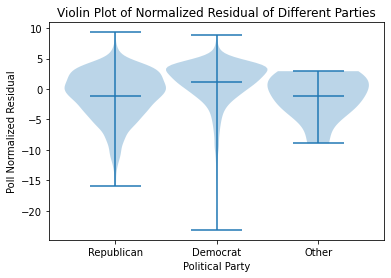

In [124]:
fig, ax = plt.subplots()

# break up into labels and data
labels = ["Republican", "Democrat", "Other"]
party_data = [data_r['norm_residual'], data_d['norm_residual'], data_o['norm_residual']]

# plot data
ax.violinplot(party_data, widths=1, showmeans=True)

# set labels
ax.set_title('Violin Plot of Normalized Residual of Different Parties')
ax.set_ylabel('Poll Normalized Residual (Higher is better)')
ax.set_xlabel('Political Party')

ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

This violin plot shows that most of the polling data is represented by a bell curve. This is expected because polls are a form of sampling so we would expect a sample of accurate polls to follow a bell curve. From this we can see that while polls of Democrats tend to be more accurate on average, there is a wider spread for the accuracy of polls of Democrats. It is interesting that the data is all skewed left but this makes sense when considering the cap on the best possible score which results in the clump of data points on the upper end.

A two sample T-Test will now be conducted to determine whether or not there is a significant difference between the polling data for Democrat vs Republican candidates. For this test we will make the assumption that both samples are normally distributed. Examining the graph both data sets do appear to be close to normally distributed. Furthermore we have far more than 30 samples so we can approximate a normal distribution anyways. We also know that the dependent variable is measured on the interval scale, in this case that's because both the percentages (predicted and actual) are on an interval scale so their difference will be as well. Furthermore we make the assumption that combined, these surveys make up an accurate sample of the general population. We do need to be careful because averaging these surveys does represent taking an average of averages, however the values that are being averaged are constrained to the interval 0-100.  

The null hypothesis is that there is no difference between samples and that a poll of a Democrat candidate will be just as accurate as that of a Republican candidate. The alternative hypothesis is that there is a significant difference between the two parties when it comes to the accuracy of the polls to find their percentage of votes received.

These values represent just a subset of all polls which in turn is attempting to represent the voting population as a whole. For this reason we will examine the variance of both groups to ensure they do not differ too much. If they do differ too much we would not be able to use a two sample t-test.

Our cutoff value for significance will be .05. Anything less than .05 and we will reject the null and accept the alternative hypothesis.

More about 2 sample t-tests https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [125]:
print(np.var(data_r['norm_residual']), np.var(data_d['norm_residual']))


15.866414553027486 12.13155187272517


Our residuals are reasonably close so we can make the assumption that both samples have equal variance. Thus, we can continue with the test.

In [126]:
stats.ttest_ind(a=data_r['norm_residual'], b=data_d['norm_residual'], equal_var=True)

Ttest_indResult(statistic=-16.85472161574355, pvalue=2.7589728555806024e-61)

We got a p-value of 2.758972855580445e-61 which is well below the .05 threshold for significance. Thus we can reject the null hypothesis and conclude that there is a significant difference between the two parties when it comes to the accuracy of the polls to find their percentage of votes received. This is not a surprising result, it is well known that Republicans tend to receive more votes in the actual election compared to polling data. This phenomenon is not entirely understood but some hypotheses that this may occur because Republican voters are generally more enthusiastic than Democrat voters and the more enthusiastic the voter the more likely they are to vote. 

More information Republican vs Democrat polling discrepancies<br>
https://www.cnn.com/2022/02/19/politics/enthusiasm-republican-midterms-high/index.html<br>
https://www.politico.com/news/2021/07/18/pollsters-2020-polls-all-wrong-500050

##### 3.2 Sponsored vs Unsponsored Polls

We will now examine to see if the quality of the data from the poll is dependent on some of the available data about the pollster collecting the data. It may be the case that polls that are sponsored are either biased towards or against their candidate. Let's plot the sponsored vs unsponsored data to see if there is a significant difference.

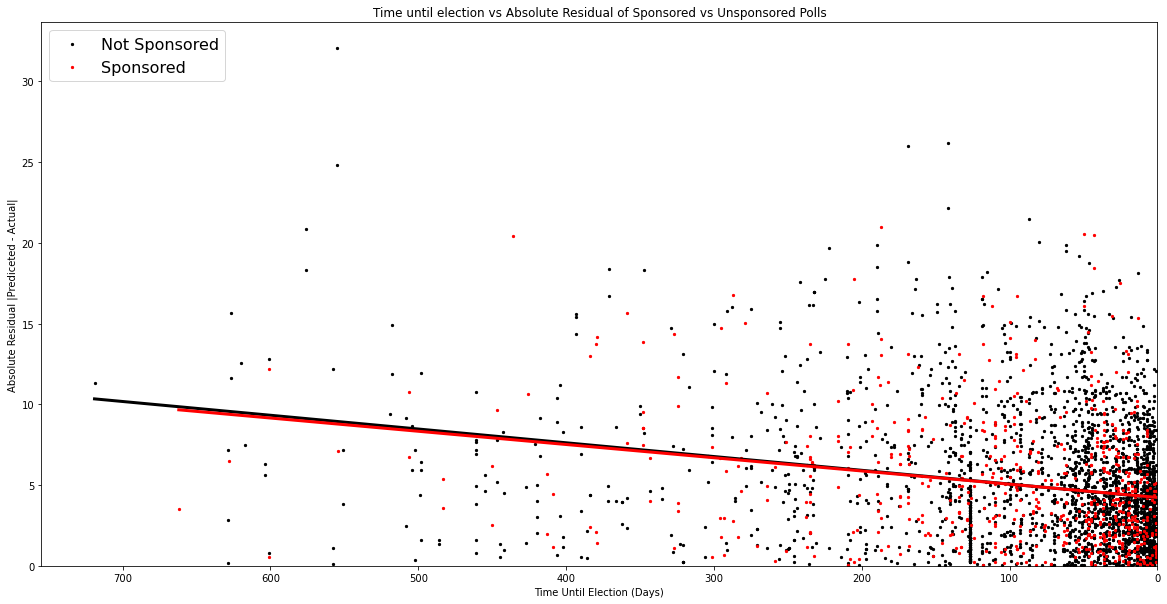

In [127]:
# break up data into partisan and not partisan
pollster_sponsored = data[~data['partisan'].isna()]
pollster_not_sponsored = data[data['partisan'].isna()]

# set graph size
plt.figure(figsize = (20, 10))

# invert axis so start of election(0 Days until election) is at the end of the graph this way time moves from left to right
plt.gca().invert_xaxis()

# set title and labels
plt.title("Time until election vs Absolute Residual of Sponsored vs Unsponsored Polls")
plt.xlabel("Time Until Election (Days)")
plt.ylabel("Absolute Residual |Prediceted - Actual|")

# plot the data
scatter(plt, pollster_not_sponsored, 'until_election', 'abs_residual', 'black', 'Not Sponsored')
scatter(plt, pollster_sponsored, 'until_election', 'abs_residual', 'red', 'Sponsored')

# add legend for context
plt.legend(loc="upper left", prop={'size': 16})

# lim x and y so plot x ends at election day y and starts at 0 which is the min possible error
plt.ylim(0)
plt.xlim(None, 0)

plt.show()

We see from this that there does not appear to be any significant difference between the sponsored and unsponsored polls. The trendlines appear almost identical and the data spreads look similar as well.

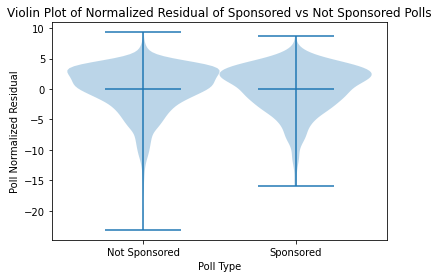

In [128]:
fig, ax = plt.subplots()

# break up into labels and data
labels = ["Not Sponsored", "Sponsored"]
party_data = [pollster_not_sponsored['norm_residual'], pollster_sponsored['norm_residual']]

# plot data
ax.violinplot(party_data, widths=1, showmeans=True)

# set labels
ax.set_title('Violin Plot of Normalized Residual of Sponsored vs Not Sponsored Polls')
ax.set_ylabel('Poll Normalized Residual (Higher is better)')
ax.set_xlabel('Poll Type')

# set labels
ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

This looks very simiar to what we expected given the scatter plot above. These violin plots follow a similar pattern to those of the parties. The data is very similar to a bell curve with a slight skew left. This is also likely caused by the cap on the best possible score which results in the clump. We will now check to see if the difference is significant.

A two sample T-Test will now be conducted to determine whether or not there is a significant difference between the polling data for sponsored vs unsponsored polls. For this test we will make the assumption that both samples are normally distributed. Examining the graph both data sets do appear to be close to normally distributed. Furthermore we have far more than 30 samples so we can approximate a normal distribution anyways. We also know that the dependent variable is measured on the interval scale, in this case that's because both the percentages (predicted and actual) are on an interval scale so their difference will be as well. Furthermore we make the assumption that combined, these surveys make up an accurate sample of the general population. We do need to be careful because averaging these surveys does represent taking an average of averages, however the values that are being averaged are constrained to the interval 0-100.  

The null hypothesis is that there is no difference between the accuracy of a sponsored vs unsponsored polls. The alternative hypothesis is that there is a significant difference between the the accuracy of a sponsored vs unsponsored polls.

These values represent just a subset of all polls which in turn is attempting to represent the voting population as a whole. For this reason we will examine the variance of both groups to ensure they do not differ too much. If they do differ too much we would not be able to use a two sample t-test.

Our cutoff value for significance will again be .05. Anything less than .05 and we will reject the null and accept the alternative hypothesis.

In [146]:
print(np.var(pollster_not_sponsored['norm_residual']), np.var(pollster_sponsored['norm_residual']))

15.193191622999079 15.05679471958638


Our residuals are reasonably close so we can make the assumption that both samples have equal variance. Thus, we can continue with the test.

In [129]:
stats.ttest_ind(a=pollster_not_sponsored['norm_residual'], b=pollster_sponsored['norm_residual'], equal_var=True)

Ttest_indResult(statistic=-0.05117896835749711, pvalue=0.9591859029973495)

From this test we see that we have a very high p value, well over .05 so we cannot reject the null hypothesis. This is not a surprise based on the data from the scatter plot and violin graph.

##### 3.3 Analysis by Pollster Rating

FiveThirtyEight provides a pollster grade for each pollster that is "Based on the historical accuracy and methodology of each polling organization’s polls". The rating is also “adjusted for the type of election polled, the poll’s sample size, the performance of other polls surveying the same race and other factors". I decided to just break the data up into general categories of A, B, and C because it will be easier to visualize the group and each individual rating is less likely to be influenced by one good/bad pollster. Furthermore if there is a significant difference between the different letter ratings I can check to see how much of a correlation there is between the individual modifiers ie +/-.

More about FiveThirtyEight pollster ratings<br>
https://projects.fivethirtyeight.com/pollster-ratings/ 


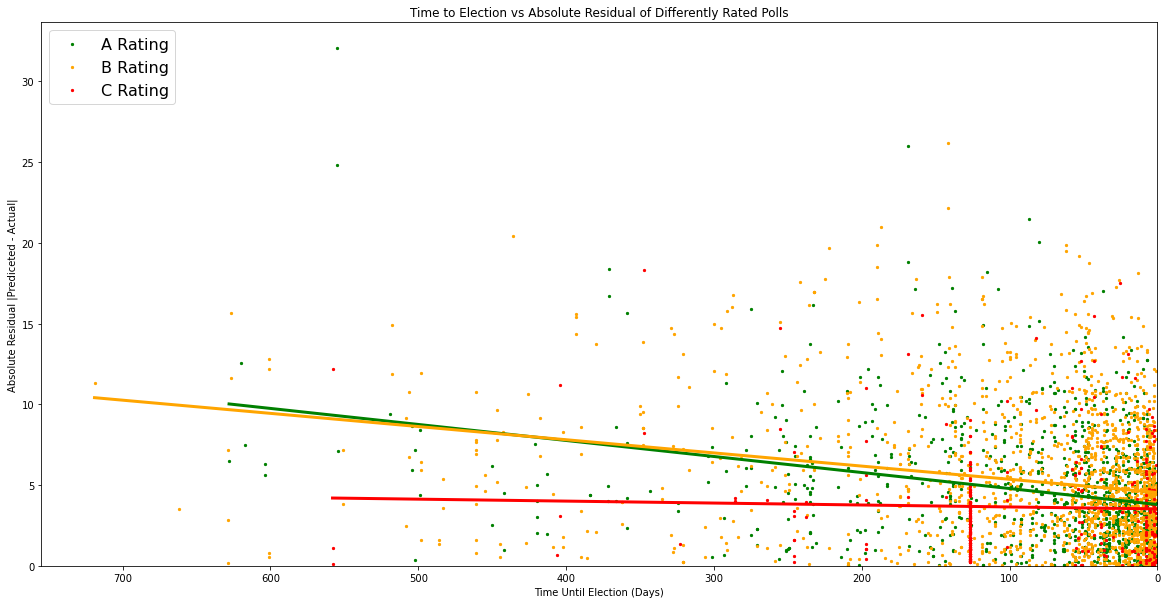

In [130]:
# break up data by rating
data_a = data[data['fte_grade'].isin(['A+', 'A', 'A-', 'A/B'])]
data_b = data[data['fte_grade'].isin(['B+', 'B', 'B-', 'B/C'])]
data_c = data[data['fte_grade'].isin(['C+', 'C', 'C-', 'C/D'])]

# set graph size
plt.figure(figsize = (20, 10))

# invert axis so start of election(0 Days until election) is at the end of the graph this way time moves from left to right
plt.gca().invert_xaxis()

# set title and labels
plt.title("Time to Election vs Absolute Residual of Differently Rated Polls")
plt.xlabel("Time Until Election (Days)")
plt.ylabel("Absolute Residual |Prediceted - Actual|")

# plot data
scatter(plt, data_a, 'until_election', 'abs_residual', 'green', 'A Rating')
scatter(plt, data_b, 'until_election', 'abs_residual', 'orange', 'B Rating')
scatter(plt, data_c, 'until_election', 'abs_residual', 'red', 'C Rating')

# add legend for context
plt.legend(loc="upper left", prop={'size': 16})

# lim x and y so plot x ends at election day y and starts at 0 which is the min possible error
plt.ylim(0)
plt.xlim(None, 0)

plt.show()

This graph is very surprising as it seems to indicate that there is little difference between polls with A and B ratings but that polls with a C rating are generally more accurate but do not get more accurate the closer to election day. It also indicates that the rating of a pollster has very little to do with their accuracy, at least in this case. I definitely would have expected polls rated A to have better accuracy than those rated B and those be more accurate than those rated C.

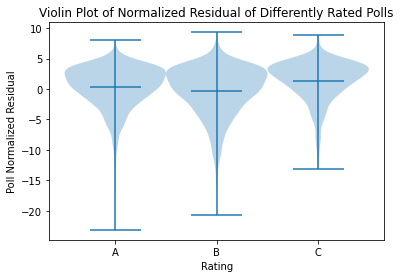

In [131]:
fig, ax = plt.subplots()

# break up into labels and data
labels = ["A", "B", "C"]
party_data = [data_a['norm_residual'], data_b['norm_residual'], data_c['norm_residual']]

# plot data
ax.violinplot(party_data, widths=1, showmeans=True)

# set labels
ax.set_title('Violin Plot of Normalized Residual of Differently Rated Polls')
ax.set_ylabel('Poll Normalized Residual')
ax.set_xlabel('Rating')

ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

We can see from this that the polls with an A rating are slightly better than those with a B rating. However we also see the strange anomoly that polls with a C rating are genreally better. This violin graph follows pretty much the same trend as those above regarding distribution and skew. Since its very strange that the C rating polls are seemingly more accurate we will look into that more.

In [149]:
print(len(data_c.index))

# get number of polls performed by each C rated pollster
data_c_pollsters = data_c.groupby('pollster')['pollster_rating_id'].count()
data_c_pollsters.sort_values(key=lambda x: x, ascending=False, inplace=True)
data_c_pollsters.head(1)

350


pollster
SurveyMonkey    175
Name: pollster_rating_id, dtype: int64

We see from this that SurveyMonkey makes up exactly half of the polls in the C rating category. Lets see how SurveyMonkey performs compared to other pollsters. If they preform well then they could be the cause of the strange result.

In [150]:
print(data[data['pollster'] == "SurveyMonkey"]["abs_residual"].mean())
print(data[data['pollster'] != "SurveyMonkey"]["abs_residual"].mean())


2.8757142857142854
5.018519888991612


This shows that SurveyMonkey is on average 2 points better than other pollsters. This may be why the best fit line for C rated pollsters appeared so low. Lets remove SurveyMonkey and regraph to see if that changes anything. This very low error from SurveyMonkey means that they are likely to be an accurate pollster. However there are many factors that go into the grade that a pollster receives so it's possible that they received a low grade due to past practices, their polling methods, or they may just be a newer pollster who has not done enough polls to receive a high rating.


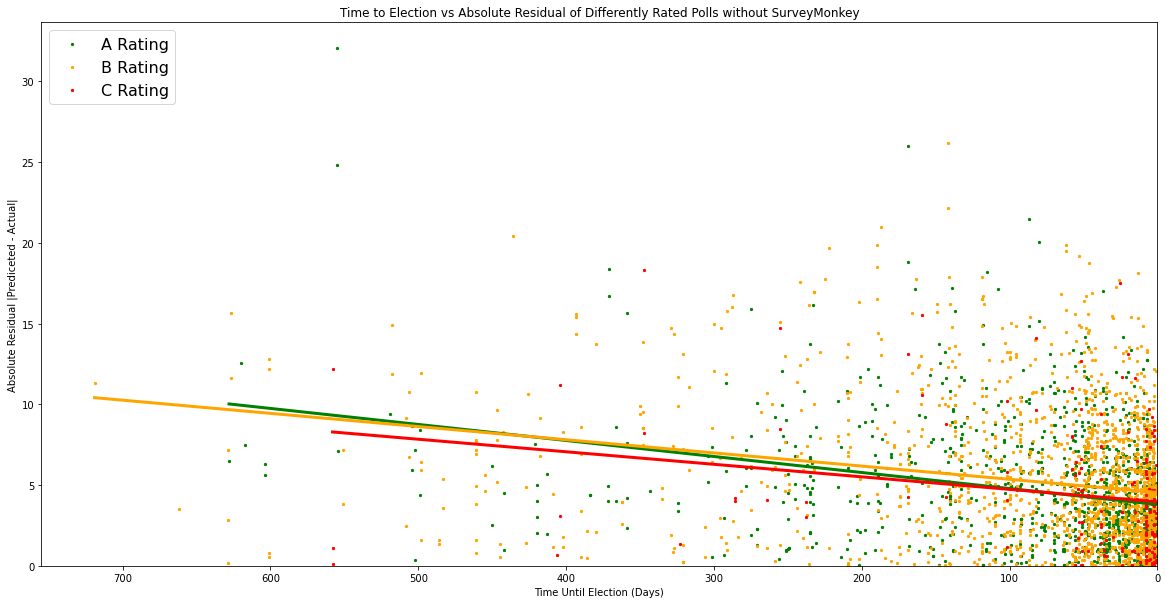

In [134]:
# remove surveyMonkey from the c results
data_c_wout = data_c[data_c['pollster'] != "SurveyMonkey"]

# set graph size
plt.figure(figsize = (20, 10))

# invert axis so start of election(0 Days until election) is at the end of the graph this way time moves from left to right
plt.gca().invert_xaxis()

# set title and labels
plt.title("Time to Election vs Absolute Residual of Differently Rated Polls without SurveyMonkey")
plt.xlabel("Time Until Election (Days)")
plt.ylabel("Absolute Residual |Prediceted - Actual|")

# plot the data
scatter(plt, data_a, 'until_election', 'abs_residual', 'green', 'A Rating')
scatter(plt, data_b, 'until_election', 'abs_residual', 'orange', 'B Rating')
scatter(plt, data_c_wout, 'until_election', 'abs_residual', 'red', 'C Rating')

# add legend for context
plt.legend(loc="upper left", prop={'size': 16})

# lim x and y so plot x ends at election day y and starts at 0 which is the min possible error
plt.ylim(0)
plt.xlim(None, 0)

plt.show()

With that we seem to have corrected the strange phaenonom of C rated pollsters not becomming more accurate over time. It seems that SurveyMonkey was just pulling the line down resulting in what seemed like a constant accuracy.

I have decided to not do a sample T-Test based on grade because I do not believe that there is a reason for the polls rated lower to be performing better other than the rating doesn't have any influence on the result. Performing a test here to try to show that there is a statistical correlation between worse grades and better polls would just be trying to find correlation where there should not be one. 

##### 3.4 Analysis by Poll Survey Method

When pollsters are collecting data there is a variety of different methods they use to get results. In this section we will examine the different survey methods used by pollsters to see if there is a distinguishable difference in accuracy between the different methods.

In [135]:
print(data['methodology'].unique())
# IVR is interactive voice response polling
print(len(data[data['methodology'] == "IVR"]))
print(len(data[data['methodology'] == "Online"]))
print(len(data[data['methodology'] == "Live Phone"]))
print(len(data[data['methodology'] == "Mail"]))
print(len(data[data['methodology'] == "Text"]))

['Live Phone/Online' 'IVR/Online/Text' 'IVR/Live Phone' 'Live Phone'
 'Online' 'IVR/Online' 'Live Phone/Text' 'IVR' 'Online/Text' 'IVR/Text'
 nan 'IVR/Live Phone/Text' 'Text' 'Mail' 'Live Phone/Online/Text'
 'IVR/Live Phone/Online']
126
1042
1147
6
12


Based on this it appears that two common forms of methodology are online and life phone polling. Since we have a large number of samples for these two methods we will examine them. Additionally trying to find correlations between mixed and matched sampling techniques where there is not data availiable about how much sampling was done using each method does not seem productive.

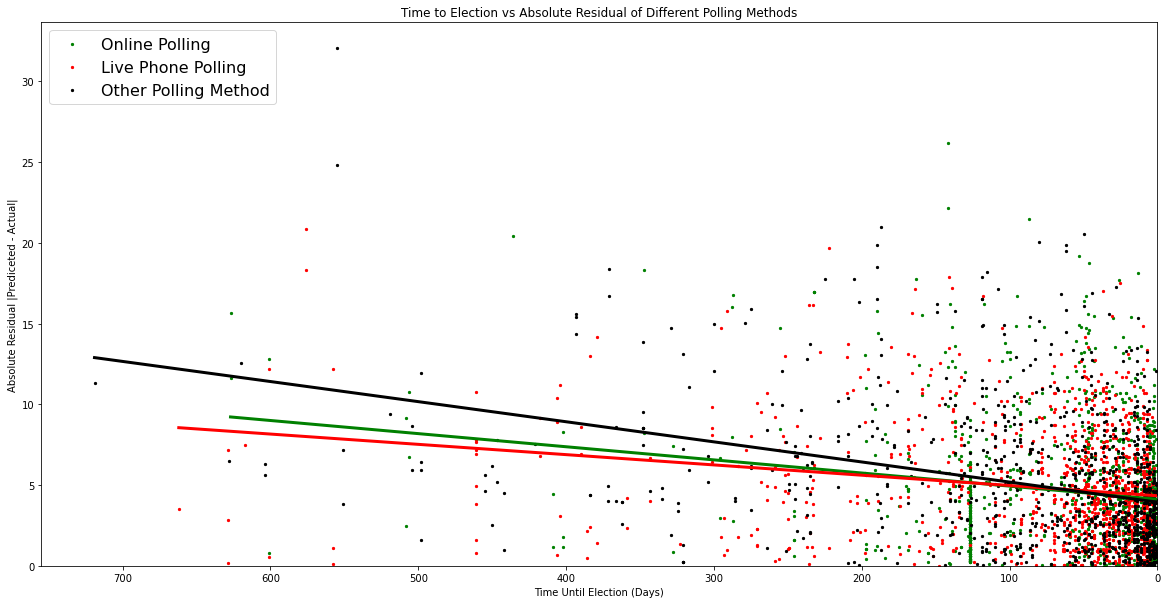

In [151]:
# get data for methodology
method_data = data[data['methodology'].notna()]
method_online = method_data[method_data['methodology'] == "Online"]
method_phone = method_data[method_data['methodology'] == "Live Phone"]
method_other =  method_data[(method_data['methodology'] != "Live Phone") & (method_data['methodology'] != "Online")]

# set graph size
plt.figure(figsize = (20, 10))

# invert axis so start of election(0 Days until election) is at the end of the graph this way time moves from left to right
plt.gca().invert_xaxis()

# set title and labels
plt.title("Time to Election vs Absolute Residual of Different Polling Methods")
plt.xlabel("Time Until Election (Days)")
plt.ylabel("Absolute Residual |Prediceted - Actual|")

# plot data
scatter(plt, method_online, 'until_election', 'abs_residual', 'green', 'Online Polling')
scatter(plt, method_phone, 'until_election', 'abs_residual', 'red', 'Live Phone Polling')
scatter(plt, method_other, 'until_election', 'abs_residual', 'black', 'Other Polling Method')

# add legend for context
plt.legend(loc="upper left", prop={'size': 16})

# lim x and y so plot x ends at election day y and starts at 0 which is the min possible error
plt.ylim(0)
plt.xlim(None, 0)

plt.show()

Based on this graph there appears to be no difference between the different polling methods. The trendlines all have a similar slope and intercept. I will once again not be performing a t-test based on the different polling methods because I do not feel that there is one based on my exploratory analysis.

##### 3.5 Analysis by Poll Sample Size

When taking a samples we find that the more of a population we sample, the more accurate the generalizations we are able to make. In this case it should be the same way. Lets look at the number of people polled compared to the accuracy of the polling data.

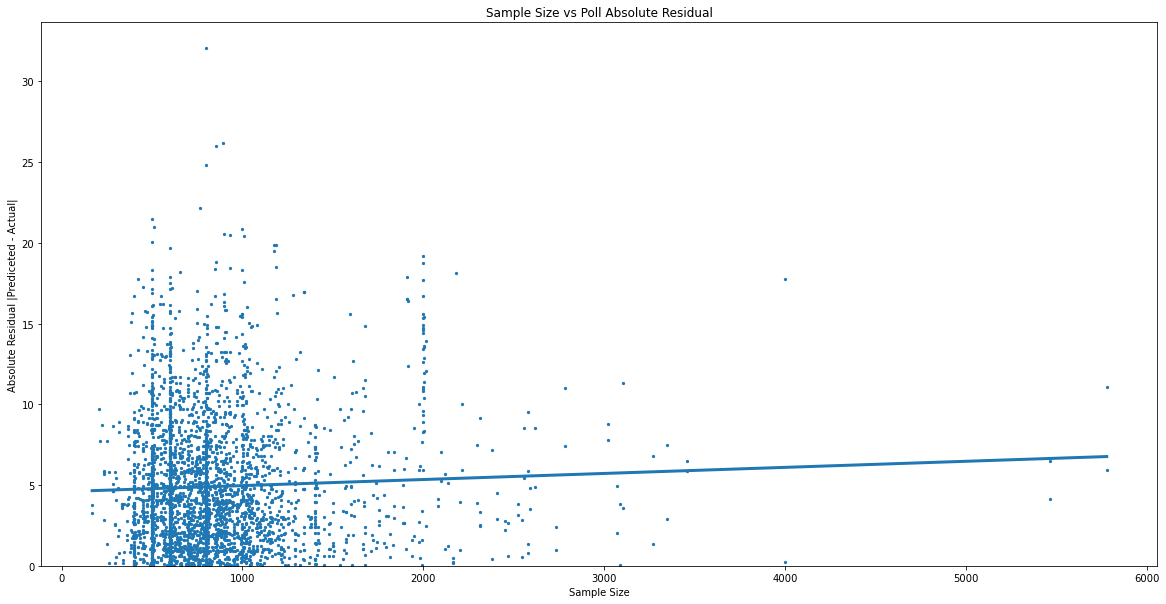

In [138]:
# get just data with a listed sample size
data_sample_size = data[~data['sample_size'].isna()]

# set graph size
plt.figure(figsize = (20, 10))

# set title and labels
plt.title("Sample Size vs Poll Absolute Residual")
plt.xlabel("Sample Size")
plt.ylabel("Absolute Residual |Prediceted - Actual|")

# plot data
scatter(plt, data_sample_size, 'sample_size', 'abs_residual')

# lim y so bottom of plot rests on 0 which is min residual
plt.ylim(0)

plt.show()

In [144]:
slope, intercept, r_value, p_value, std_err = stats.linregress(data_sample_size['sample_size'], data_sample_size['abs_residual'])
print('r value: ' + str(r_value))
print('p value: ' + str(p_value))

r value:0.04123051397762277
p value:0.016110976876576182


This means that there is some correlation because our P value is significant but we see from our r value that the line does not account for much of the variation of the data. One potentiall reason for the line sloping up could be that polls with larger sample sizes are not doing their due dilligance to get truly random samples which is compromising their results. Its also possibly jsut a coincidence and more data would lead to a trend line that suggests polls with more samples are generally more accurate. The p value being stastically significant does not indicate that the exact line's slope is significant, just that the data is generally fitted by the line.

#### 4. Conclusion

I was surprised by a lot of the results. I expected there to be a lot more correlations between different data points and the accuracy of polls. Based on my findings it seems that most Senate polling data is not very accurate with an ability to only predict the results to around 4.2% accuracy right before the election. I was able to conclude that Republicans poll worse than Democrats, and that the ratings provided by fivethirtyeight are not a good measure of a polls accuracy for senate elections. I was hoping to be able to fit a model to predict the rating of a pollster but based on my exploratory analysis of the rating of pollsters that effort would have been futile. Additionally, I was very surprised by the fact that there was no clear correlation between sample size and accuracy. Based on my findings it's difficult to use polls to gauge the results of senate elections so do not rely too heavily on them to reliably predict a candidate's results. Future testing should go to see how the polls listed by fivethirtyeight compare to other polls. Additionally, it would be good to include other types of elections in the data such as House of Representatives elections and state elections. This could give a more complete picture as to what affects the accuracy of a poll and how much polls can be relied on by politicians and citizens alike. 